## Trilateration Notebook
### Experiments based on the computation of the intersection of three or more beacons to compute the user's position

### Imports
Imports of required libraries

In [1]:
#CSV Related
import pandas as pd
import csv

# Machine Learning
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import  accuracy_score
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.model_selection import train_test_split,KFold,StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.pipeline import make_pipeline
import sklearn
import scipy

#Graphical Display
%matplotlib inline
import math
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.despine()
from pandas.plotting import scatter_matrix

plt.style.use('seaborn-whitegrid')

#Additional Helper Libraries
from operator import itemgetter
import re

<Figure size 432x288 with 0 Axes>

### Load File
Function that allows to load a file from disk

In [2]:
#Function that reads a csv file and structures the data accordingly
def load_file(filename):
    dataset = pd.read_csv(filename)
    return dataset

### Replace 0 with Nan RSSI Values

In [3]:
def replace_features_nan(dataset):
    dataset['rssi_Value'] = dataset['rssi_Value'].replace(0,np.nan)
    dataset['rolling_mean_rssi'] = dataset['rolling_mean_rssi'].replace(0,np.nan)

### Initialize Dataset
Initialization of the data from the file

In [4]:
dataset = load_file('trilateration_test.csv')
display(dataset)
display(dataset.shape)

,X,Y,FF:20:88:3C:97:E7,CA:E0:7D:11:26:B3,E1:E9:C3:D9:09:C3
0,-2.0,-1.0,0.000000,3.162278,3.605551
1,-2.0,-0.5,0.500000,2.692582,3.354102
2,-2.0,0.0,1.000000,2.236068,3.162278
3,-2.0,0.5,1.500000,1.802776,3.041381
4,-2.0,1.0,2.000000,1.414214,3.000000
...,...,...,...,...,...
95,2.5,1.5,5.147815,3.535534,1.581139
96,2.5,2.0,5.408327,3.500000,1.802776
97,2.5,2.5,5.700877,3.535534,2.121320
98,2.5,3.0,6.020797,3.640055,2.500000


(100, 5)

### Initialize Training Dataset
Initialization of the data from the file

,coordinate_X,coordinate_Y,rssi_Value,rolling_mean_rssi,zone,distance
0,0.0,0.0,-48,-48.000000,Personal,0.0
1,0.0,0.0,-48,-48.000000,Personal,0.0
2,0.0,0.0,-48,-48.000000,Personal,0.0
3,0.0,0.0,-48,-48.000000,Personal,0.0
4,0.0,0.0,-46,-47.600000,Personal,0.0
...,...,...,...,...,...,...
24829,0.0,4.5,-92,-90.480000,Public,4.5
24830,0.0,4.5,-93,-90.576923,Public,4.5
24831,0.0,4.5,-90,-90.555556,Public,4.5
24832,0.0,4.5,-90,-90.535714,Public,4.5


(24834, 6)

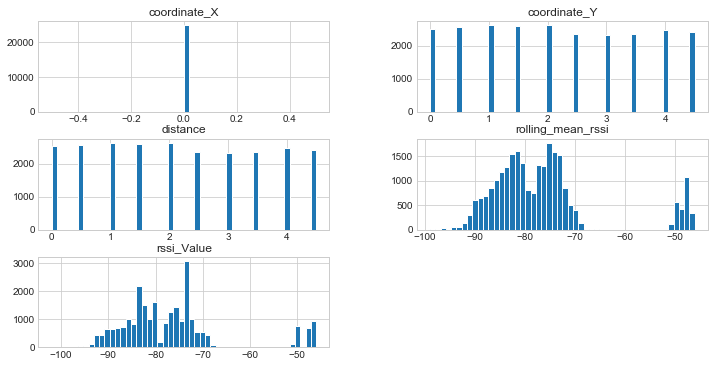

In [5]:
train_dataset = load_file('../../dataset_train_university.csv')
positions = train_dataset['coordinate_Y']
train_dataset['distance'] = positions
replace_features_nan(train_dataset)
display(train_dataset)
display(train_dataset.shape)
train_dataset.hist(bins=50,figsize=(12,6))
plt.show()

### Initialize Test Set

,BLE Beacon,coordinate_X,coordinate_Y,rssi_Value,rolling_mean_rssi,zone,distance
0,FF:20:88:3C:97:E7,1.0,2.0,-84,-84.000000,NaN,2.0
1,FF:20:88:3C:97:E7,1.0,2.0,-83,-83.500000,NaN,2.0
2,FF:20:88:3C:97:E7,1.0,2.0,-84,-83.666667,NaN,2.0
3,FF:20:88:3C:97:E7,1.0,2.0,-83,-83.500000,NaN,2.0
4,FF:20:88:3C:97:E7,1.0,2.0,-85,-83.800000,NaN,2.0
...,...,...,...,...,...,...,...
13473,E1:E9:C3:D9:09:C3,0.0,0.0,-80,-81.483636,NaN,0.0
13474,E1:E9:C3:D9:09:C3,0.0,0.0,-83,-81.489130,NaN,0.0
13475,E1:E9:C3:D9:09:C3,0.0,0.0,-85,-81.501805,NaN,0.0
13476,E1:E9:C3:D9:09:C3,0.0,0.0,-84,-81.510791,NaN,0.0


(13478, 7)

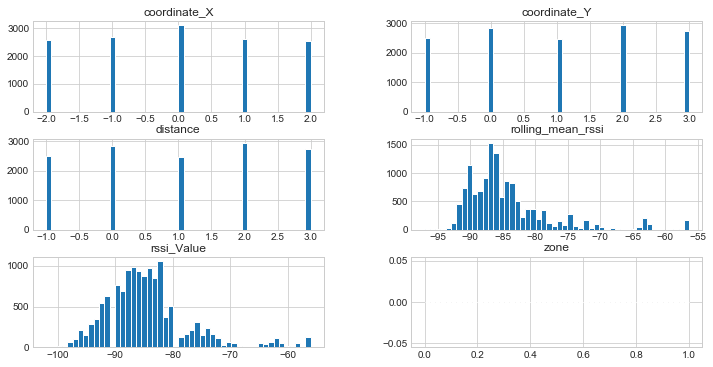

In [6]:
test_dataset = load_file('dataset_test_trilateration_university.csv')
positions = test_dataset['coordinate_Y']
test_dataset['distance'] = positions
replace_features_nan(test_dataset)
display(test_dataset)
display(test_dataset.shape)
test_dataset.hist(bins=50,figsize=(12,6))
plt.show()

### File Overall Description
Usage of describe pandas function on the dataset

In [7]:
display(dataset.describe().transpose())

,count,mean,std,min,25%,50%,75%,max
X,100.0,0.250000,1.443376,-2.0,-1.000000,0.250000,1.500000,2.500000
Y,100.0,1.250000,1.443376,-1.0,0.000000,1.250000,2.500000,3.500000
FF:20:88:3C:97:E7,100.0,3.501523,1.417544,0.0,2.500000,3.622803,4.548212,6.363961
CA:E0:7D:11:26:B3,100.0,2.271980,1.048379,0.0,1.478553,2.236068,3.071605,4.609772
E1:E9:C3:D9:09:C3,100.0,2.014310,0.836392,0.0,1.478553,2.061553,2.549510,3.905125


### % of Missing Values on Test Dataset

In [8]:
def compute_missing_values(dataset): 
    missing_values = dataset.isnull().sum()
    missing_values_dataset = pd.DataFrame(missing_values,columns=['Missing Values'])
    missing_percentage = (dataset.isnull().sum() / dataset.count())
    missing_percentage_dataset = pd.DataFrame(missing_percentage,columns=['% of Missing Values'])
    missing_dataset = missing_values_dataset.join(missing_percentage_dataset)
    display(missing_dataset)

In [9]:
compute_missing_values(test_dataset)
compute_missing_values(train_dataset)

,Missing Values,% of Missing Values
BLE Beacon,0,0.0
coordinate_X,0,0.0
coordinate_Y,0,0.0
rssi_Value,0,0.0
rolling_mean_rssi,0,0.0
zone,13478,inf
distance,0,0.0


,Missing Values,% of Missing Values
coordinate_X,0,0.0
coordinate_Y,0,0.0
rssi_Value,0,0.0
rolling_mean_rssi,0,0.0
zone,0,0.0
distance,0,0.0


### Overall Histogram of dataset atributes

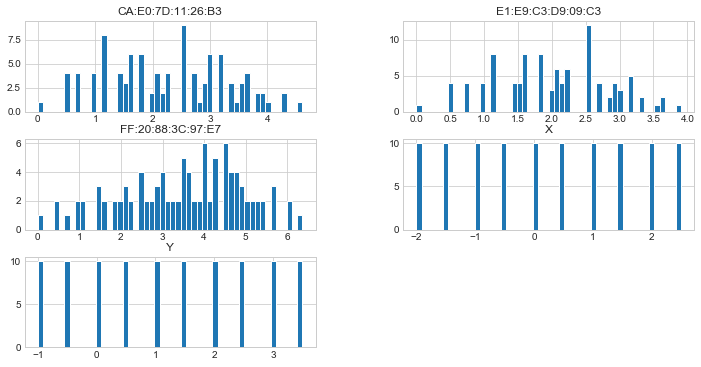

In [10]:
dataset.hist(bins=50,figsize=(12,6))
plt.show()

### Beacon RSSI Display of Test Dataset
Graphical display of the rssi values recorded at each position

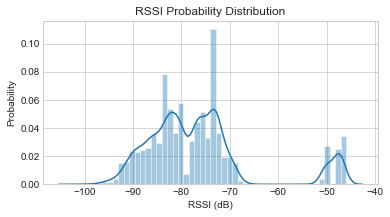

In [11]:
plt.figure(figsize=(6,3))
# Title
plt.title('RSSI Probability Distribution')

sns.distplot(train_dataset['rssi_Value'])
# The X Label
plt.xlabel('RSSI (dB)')
# The Y Label
plt.ylabel('Probability')
# Show the plot
plt.show()

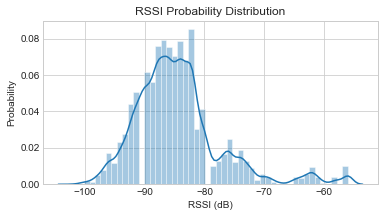

In [12]:
plt.figure(figsize=(6,3))
# Title
plt.title('RSSI Probability Distribution')

sns.distplot(test_dataset['rssi_Value'])
# The X Label
plt.xlabel('RSSI (dB)')
# The Y Label
plt.ylabel('Probability')
# Show the plot
plt.show()

### Beacon Rolling Mean RSSI Display of Test Dataset
Graphical adisplay of the rolling mean value recorded at each position

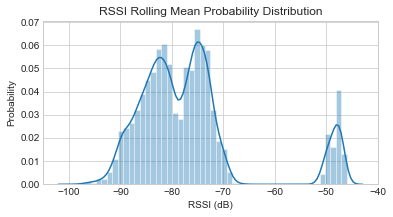

In [13]:
plt.figure(figsize=(6,3))
# Title
plt.title('RSSI Rolling Mean Probability Distribution')
# The KDE plot for the Rolling Mean column
sns.distplot(train_dataset['rolling_mean_rssi'])
# The X Label
plt.xlabel('RSSI (dB)')
# The Y Label
plt.ylabel('Probability')
# Show the plot
plt.show()

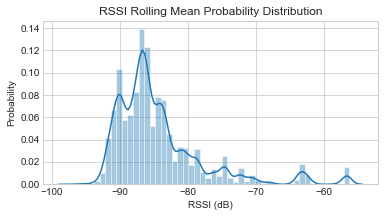

In [14]:
plt.figure(figsize=(6,3))
# Title
plt.title('RSSI Rolling Mean Probability Distribution')
# The KDE plot for the Rolling Mean column
sns.distplot(test_dataset['rolling_mean_rssi'])
# The X Label
plt.xlabel('RSSI (dB)')
# The Y Label
plt.ylabel('Probability')
# Show the plot
plt.show()

### Graphical Display of RSSI/Rolling Mean Distribution of Test Dataset
Graphical display of the previous measures - rssi and rolling mean

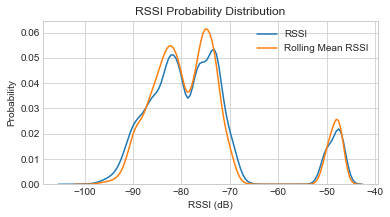

In [15]:
plt.figure(figsize=(6,3))
# Title
plt.title('RSSI Probability Distribution')
# The KDE plot for the RSSI column
sns.kdeplot(train_dataset['rssi_Value'], label='RSSI')
# The KDE plot for the Rolling Mean column
sns.kdeplot(train_dataset['rolling_mean_rssi'], label='Rolling Mean RSSI')
# The X Label
plt.xlabel('RSSI (dB)')
# The Y Label
plt.ylabel('Probability')
# Show the plot
plt.show()

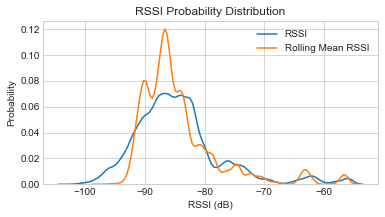

In [16]:
plt.figure(figsize=(6,3))
# Title
plt.title('RSSI Probability Distribution')
# The KDE plot for the RSSI column
sns.kdeplot(test_dataset['rssi_Value'], label='RSSI')
# The KDE plot for the Rolling Mean column
sns.kdeplot(test_dataset['rolling_mean_rssi'], label='Rolling Mean RSSI')
# The X Label
plt.xlabel('RSSI (dB)')
# The Y Label
plt.ylabel('Probability')
# Show the plot
plt.show()

### Correlations
Check how much each attribute collerates with each other. Valures frange from -1 to 1. Close to 1 means a strong positive correlation.

In [17]:
def compute_correlations(dataset,attribute,flag=0):
    corr_matrix = dataset.corr()
    display(corr_matrix)
    display(corr_matrix[attribute].sort_values(ascending=False))
    if flag == 1:
        attributes = ["distance","rssi_Value", "rolling_mean_rssi"]
        scatter_matrix(dataset[attributes], figsize=(12, 8))

,X,Y,FF:20:88:3C:97:E7,CA:E0:7D:11:26:B3,E1:E9:C3:D9:09:C3
X,1.000000,0.000000,0.686799,0.721364,-0.580793
Y,0.000000,1.000000,0.686799,-0.437939,0.194834
FF:20:88:3C:97:E7,0.686799,0.686799,1.000000,0.236106,-0.171257
CA:E0:7D:11:26:B3,0.721364,-0.437939,0.236106,1.000000,-0.157819
E1:E9:C3:D9:09:C3,-0.580793,0.194834,-0.171257,-0.157819,1.000000


X                    1.000000
CA:E0:7D:11:26:B3    0.721364
FF:20:88:3C:97:E7    0.686799
Y                    0.000000
E1:E9:C3:D9:09:C3   -0.580793
Name: X, dtype: float64

,coordinate_X,coordinate_Y,rssi_Value,rolling_mean_rssi,distance
coordinate_X,NaN,NaN,NaN,NaN,NaN
coordinate_Y,NaN,1.000000,-0.723705,-0.741381,1.000000
rssi_Value,NaN,-0.723705,1.000000,0.958999,-0.723705
rolling_mean_rssi,NaN,-0.741381,0.958999,1.000000,-0.741381
distance,NaN,1.000000,-0.723705,-0.741381,1.000000


distance             1.000000
coordinate_Y         1.000000
rssi_Value          -0.723705
rolling_mean_rssi   -0.741381
coordinate_X              NaN
Name: distance, dtype: float64

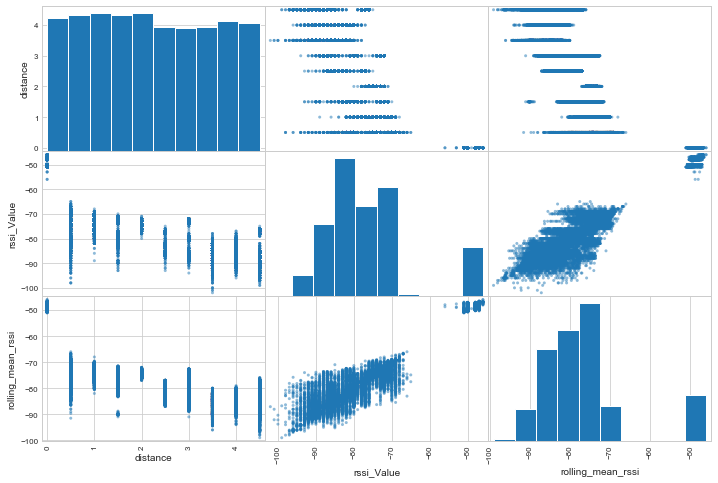

In [18]:
compute_correlations(dataset,'X')
compute_correlations(train_dataset,'distance',1)

### Data Cleaning
Fill in missing values and fix/remove outliers

In [19]:
def compute_data_cleaning(dataset,feature):
    nan_filler = dataset[feature].min()*1.010
    dataset[feature] = dataset[feature].fillna(nan_filler) # Fill missing values

In [20]:
compute_data_cleaning(train_dataset,'rssi_Value')
compute_data_cleaning(train_dataset,'rolling_mean_rssi')
compute_data_cleaning(test_dataset,'rssi_Value')
compute_data_cleaning(test_dataset,'rolling_mean_rssi')

### Dealing with Categorical Data
Using Hot-Encoder or Label Encoder to convert text/categorical data into numerical data. ML algorithms prefer it

In [21]:
label_encoder = LabelEncoder()
def compute_encoder(categorical_data,flag):
    if flag == 0:
        labels = label_encoder.fit_transform(categorical_data)
    else:
        labels = label_encoder.transform(categorical_data)
    return labels

In [22]:
categorical_zone = train_dataset[['zone']]
print("Previous Categorical Data")
display(categorical_zone)
zone_changed = compute_encoder(categorical_zone,0)
print("After One Hot Encoder")
train_dataset['labels'] = zone_changed
display(train_dataset.head(5))

Previous Categorical Data


,zone
0,Personal
1,Personal
2,Personal
3,Personal
4,Personal
...,...
24829,Public
24830,Public
24831,Public
24832,Public


After One Hot Encoder


D:\Programs\Anaconda\lib\site-packages\sklearn\preprocessing\_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,coordinate_X,coordinate_Y,rssi_Value,rolling_mean_rssi,zone,distance,labels
0,0.0,0.0,-48,-48.0,Personal,0.0,0
1,0.0,0.0,-48,-48.0,Personal,0.0,0
2,0.0,0.0,-48,-48.0,Personal,0.0,0
3,0.0,0.0,-48,-48.0,Personal,0.0,0
4,0.0,0.0,-46,-47.6,Personal,0.0,0


In [23]:
categorical_zone = test_dataset[['zone']]
print("Previous Categorical Data")
display(categorical_zone)
zone_changed = compute_encoder(categorical_zone,0)
print("After One Hot Encoder")
test_dataset['labels'] = zone_changed
display(test_dataset.head(5))

Previous Categorical Data


,zone
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
13473,NaN
13474,NaN
13475,NaN
13476,NaN


After One Hot Encoder


D:\Programs\Anaconda\lib\site-packages\sklearn\preprocessing\_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,BLE Beacon,coordinate_X,coordinate_Y,rssi_Value,rolling_mean_rssi,zone,distance,labels
0,FF:20:88:3C:97:E7,1.0,2.0,-84,-84.000000,NaN,2.0,0
1,FF:20:88:3C:97:E7,1.0,2.0,-83,-83.500000,NaN,2.0,8977
2,FF:20:88:3C:97:E7,1.0,2.0,-84,-83.666667,NaN,2.0,8978
3,FF:20:88:3C:97:E7,1.0,2.0,-83,-83.500000,NaN,2.0,8979
4,FF:20:88:3C:97:E7,1.0,2.0,-85,-83.800000,NaN,2.0,8980


### Plot Dataset
Graphical Display of the observations in the dataset

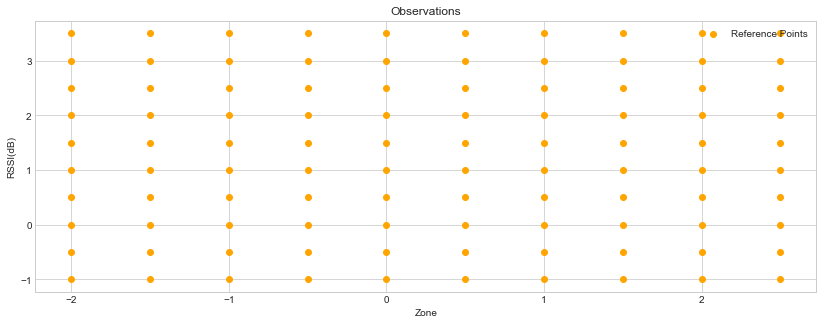

In [24]:
plt.figure(figsize=(14,5))
plt.scatter(dataset['X'],dataset['Y'],label='Reference Points',color='orange')
plt.title('Observations')  
plt.xlabel('Zone')  
plt.ylabel('RSSI(dB)')  
plt.legend(loc='upper right');
plt.show()

### Initialize Training Data
Training Data intialization for predictions purposes

In [25]:
trainX_data = train_dataset[['rssi_Value','rolling_mean_rssi']]
display(trainX_data.shape)
default_groups = train_dataset['labels'].values.reshape(-1,1)
initial_prediction = tuple()

(24834, 2)

In [26]:
train_Y = pd.DataFrame(train_dataset['distance']).values.reshape(-1,1)
display(train_Y.shape)

(24834, 1)

In [27]:
data_plot_means = train_dataset.groupby(['distance'])[['rssi_Value','rolling_mean_rssi']].mean()
display(data_plot_means)

,rssi_Value,rolling_mean_rssi
distance,,
0.0,-48.351984,-48.325565
0.5,-75.304314,-75.253245
1.0,-74.156908,-74.155786
1.5,-78.266151,-78.279493
2.0,-74.711171,-74.732949
2.5,-82.396866,-82.373984
3.0,-79.297379,-79.557064
3.5,-86.335602,-86.250861
4.0,-84.817666,-84.750632


### Plot Training Data
Graphical Display of the observations in the dataset

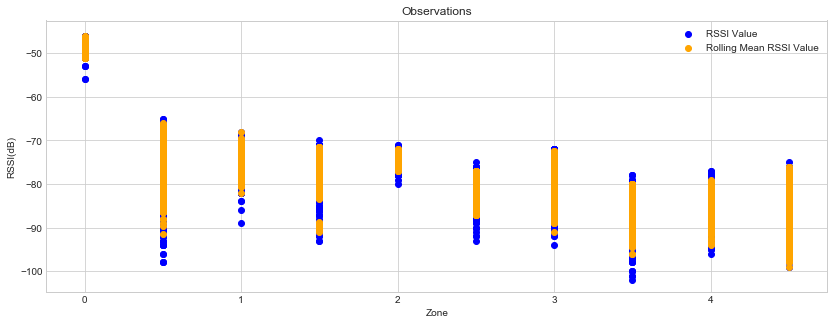

In [28]:
plt.figure(figsize=(14,5))
plt.scatter(train_dataset['distance'],train_dataset['rssi_Value'],label='RSSI Value',color='blue')
plt.scatter(train_dataset['distance'],train_dataset['rolling_mean_rssi'],label='Rolling Mean RSSI Value',color='orange')
plt.title('Observations')  
plt.xlabel('Zone')  
plt.ylabel('RSSI(dB)')  
plt.legend(loc='upper right');
plt.show()

### Initialize Test Data

In [29]:
test_X_rssi = pd.DataFrame(test_dataset['rssi_Value']).values.reshape(-1,1)
display(test_X_rssi.shape)
test_X_rolling_mean = pd.DataFrame(test_dataset['rolling_mean_rssi']).values.reshape(-1,1)
display(test_X_rolling_mean.shape)
test_combination_features_X = test_dataset[['rssi_Value','rolling_mean_rssi']]
display(test_combination_features_X.shape)

(13478, 1)

(13478, 1)

(13478, 2)

In [30]:
test_Y = pd.DataFrame(test_dataset['distance']).values.reshape(-1,1)
display(test_Y.shape)

(13478, 1)

In [31]:
data_plot_means = test_dataset.groupby(['distance'])[['rssi_Value','rolling_mean_rssi']].mean()
display(data_plot_means)

,rssi_Value,rolling_mean_rssi
distance,,
-1.0,-84.395692,-84.171189
0.0,-84.685042,-84.442653
1.0,-86.000000,-85.916756
2.0,-85.490940,-85.350581
3.0,-81.762304,-81.866541


### Plot Test Data

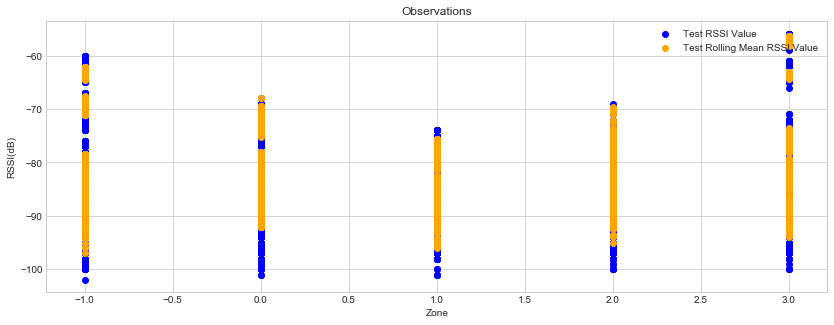

In [32]:
plt.figure(figsize=(14,5))
plt.scatter(test_dataset['distance'],test_dataset['rssi_Value'],label='Test RSSI Value',color='blue')
plt.scatter(test_dataset['distance'],test_dataset['rolling_mean_rssi'],label='Test Rolling Mean RSSI Value',color='orange')
plt.title('Observations')  
plt.xlabel('Zone')  
plt.ylabel('RSSI(dB)')  
plt.legend(loc='upper right');
plt.show()

### Statistics Output Format
Structure of the statistical output of each call to the machine learning algorithm

In [33]:
def structure_data(data):
    mae = data['error'].abs().mean()
    mse = np.power(data['error'],2).mean()
    rsme = np.sqrt(mse)
    std = data['error'].std()
    q25 = data['error'].quantile(q=0.25)
    q50= data['error'].quantile(q=0.5)
    q75 =data['error'].quantile(q=0.7)
    q95= data['error'].quantile(q=0.95)
    minValue= data['error'].min()
    maxValue = data['error'].max()
    statistical_results = [mae,mse,rsme,std,q25,q50,q75,q95,minValue,maxValue]
    return statistical_results

### Proximity ML Algorithm to compute Distances

In [34]:
def compute_KNN_with_Regression(testX_data=None, scaler=None, n_neighbors=5,
                                weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski',
                                metric_params=None, n_jobs=1):
    # Init the KNN Regressor Estimator
    knn_regression_estimator = KNeighborsRegressor(n_neighbors, weights, algorithm, leaf_size, p, metric, metric_params,
                                                   n_jobs)
    if scaler is not None:
        # Make pipeline using scaler transformation
        main_estimator = make_pipeline(scaler, knn_regression_estimator)
    else:
        main_estimator = knn_regression_estimator
    # Fit the training data
    main_estimator.fit(trainX_data, train_Y)
    # Predict the results of the testing data features
    predict_test = main_estimator.predict(testX_data)
    return predict_test

In [35]:
distances = {}
beacons = []
def compute_distance(flag=0):
    rf = test_dataset.groupby((['BLE Beacon']))
    for k, v in rf:
        if flag == 0:
            print("BEACON " + str(k))
            display(v)
        test_combination_features_X = v[['rssi_Value','rolling_mean_rssi']]
        prediction_list = compute_KNN_with_Regression(testX_data=test_combination_features_X,scaler=StandardScaler(),n_neighbors=30,
                                                      metric='manhattan')
        if flag == 0:
            display(prediction_list.shape)
        distances[k] = np.mean(prediction_list)
        beacons.append(k)
        if flag == 0:
            print("PREDICTION: " + str(distances[k]))
            print("\n")
    if flag == 0:
        print("DISTANCES ESTIMATIONS")
        print(distances)

### Compute Trilateration Method

In [36]:
def compute_squared_errors(d1,d2):
    squared_errors = math.pow(d1 - d2, 2.0)
    return squared_errors

In [37]:
def compute_display(results_mse):
    xs = []
    ys = []
    for k,v in results_mse.items():
        xs.append(str(k))
        ys.append(v)
    plt.figure(figsize=(23,8))
    plt.plot(xs,ys)
    plt.show()

In [38]:
def compute_trilateration(flag = 0):
    results_mse = {}
    for index, row in dataset.iterrows():
        x = row['X']
        y = row['Y']
        squared_errors = 0.0
        for beacon in beacons:
            distance_known = row[beacon]
            squared_errors += compute_squared_errors(distance_known,distances[beacon])
        mse = squared_errors / len(beacons)
        if flag == 0:
            print('MSE FOR POINT: x: ' + str(x) + ", y: " + str(y) + " is " + str(mse))
        results_mse[(x,y)] = mse
    prediction = min(results_mse,key=results_mse.get)
    print("PREDICTION is " + str(prediction))
    if flag == 0:
        compute_display(results_mse)
    return prediction

### Experiment - Compute Distances
Make initial prediction on distances 

In [39]:
compute_distance()

BEACON CA:E0:7D:11:26:B3


,BLE Beacon,coordinate_X,coordinate_Y,rssi_Value,rolling_mean_rssi,zone,distance,labels
180,CA:E0:7D:11:26:B3,1.0,2.0,-91,-91.000000,NaN,2.0,8946
181,CA:E0:7D:11:26:B3,1.0,2.0,-85,-88.000000,NaN,2.0,8923
182,CA:E0:7D:11:26:B3,1.0,2.0,-84,-86.666667,NaN,2.0,8922
183,CA:E0:7D:11:26:B3,1.0,2.0,-96,-89.000000,NaN,2.0,8921
184,CA:E0:7D:11:26:B3,1.0,2.0,-82,-87.600000,NaN,2.0,8908
...,...,...,...,...,...,...,...,...
13194,CA:E0:7D:11:26:B3,0.0,0.0,-90,-88.258197,NaN,0.0,4216
13195,CA:E0:7D:11:26:B3,0.0,0.0,-92,-88.273469,NaN,0.0,4217
13196,CA:E0:7D:11:26:B3,0.0,0.0,-91,-88.284553,NaN,0.0,4218
13197,CA:E0:7D:11:26:B3,0.0,0.0,-90,-88.291498,NaN,0.0,4219


(4525, 1)

PREDICTION: 3.3152154696132596


BEACON E1:E9:C3:D9:09:C3


,BLE Beacon,coordinate_X,coordinate_Y,rssi_Value,rolling_mean_rssi,zone,distance,labels
364,E1:E9:C3:D9:09:C3,1.0,2.0,-87,-87.000000,NaN,2.0,9077
365,E1:E9:C3:D9:09:C3,1.0,2.0,-87,-87.000000,NaN,2.0,9079
366,E1:E9:C3:D9:09:C3,1.0,2.0,-86,-86.666667,NaN,2.0,9105
367,E1:E9:C3:D9:09:C3,1.0,2.0,-87,-86.750000,NaN,2.0,9106
368,E1:E9:C3:D9:09:C3,1.0,2.0,-89,-87.200000,NaN,2.0,9107
...,...,...,...,...,...,...,...,...
13473,E1:E9:C3:D9:09:C3,0.0,0.0,-80,-81.483636,NaN,0.0,4493
13474,E1:E9:C3:D9:09:C3,0.0,0.0,-83,-81.489130,NaN,0.0,4494
13475,E1:E9:C3:D9:09:C3,0.0,0.0,-85,-81.501805,NaN,0.0,4495
13476,E1:E9:C3:D9:09:C3,0.0,0.0,-84,-81.510791,NaN,0.0,10107


(4450, 1)

PREDICTION: 3.1231011235955055


BEACON FF:20:88:3C:97:E7


,BLE Beacon,coordinate_X,coordinate_Y,rssi_Value,rolling_mean_rssi,zone,distance,labels
0,FF:20:88:3C:97:E7,1.0,2.0,-84,-84.000000,NaN,2.0,0
1,FF:20:88:3C:97:E7,1.0,2.0,-83,-83.500000,NaN,2.0,8977
2,FF:20:88:3C:97:E7,1.0,2.0,-84,-83.666667,NaN,2.0,8978
3,FF:20:88:3C:97:E7,1.0,2.0,-83,-83.500000,NaN,2.0,8979
4,FF:20:88:3C:97:E7,1.0,2.0,-85,-83.800000,NaN,2.0,8980
...,...,...,...,...,...,...,...,...
12946,FF:20:88:3C:97:E7,0.0,0.0,-88,-87.603175,NaN,0.0,5020
12947,FF:20:88:3C:97:E7,0.0,0.0,-86,-87.596838,NaN,0.0,5021
12948,FF:20:88:3C:97:E7,0.0,0.0,-86,-87.590551,NaN,0.0,5022
12949,FF:20:88:3C:97:E7,0.0,0.0,-85,-87.580392,NaN,0.0,5023


(4503, 1)

PREDICTION: 3.0918276704419276


DISTANCES ESTIMATIONS
{'CA:E0:7D:11:26:B3': 3.3152154696132596, 'E1:E9:C3:D9:09:C3': 3.1231011235955055, 'FF:20:88:3C:97:E7': 3.0918276704419276}


### Experiment - Compute Trilateration
Make initial prediction on trilateration

MSE FOR POINT: x: -2.0, y: -1.0 is 3.2718488221020263
MSE FOR POINT: x: -2.0, y: -0.5 is 2.386201332503074
MSE FOR POINT: x: -2.0, y: 0.0 is 1.847279037859713
MSE FOR POINT: x: -2.0, y: 0.5 is 1.6093559042367012
MSE FOR POINT: x: -2.0, y: 1.0 is 1.607016599967955
MSE FOR POINT: x: -2.0, y: 1.5 is 1.7281815288713822
MSE FOR POINT: x: -2.0, y: 2.0 is 1.790063264271061
MSE FOR POINT: x: -2.0, y: 2.5 is 1.682524166590911
MSE FOR POINT: x: -2.0, y: 3.0 is 1.5571144601812004
MSE FOR POINT: x: -2.0, y: 3.5 is 1.6273282148706805
MSE FOR POINT: x: -1.5, y: -1.0 is 2.2662373241861027
MSE FOR POINT: x: -1.5, y: -0.5 is 2.105435724024056
MSE FOR POINT: x: -1.5, y: 0.0 is 1.8842926410826983
MSE FOR POINT: x: -1.5, y: 0.5 is 1.8727365400694378
MSE FOR POINT: x: -1.5, y: 1.0 is 2.0924425841152696
MSE FOR POINT: x: -1.5, y: 1.5 is 2.4751155687247426
MSE FOR POINT: x: -1.5, y: 2.0 is 2.704443116150513
MSE FOR POINT: x: -1.5, y: 2.5 is 2.34740478928038
MSE FOR POINT: x: -1.5, y: 3.0 is 1.905349779630121

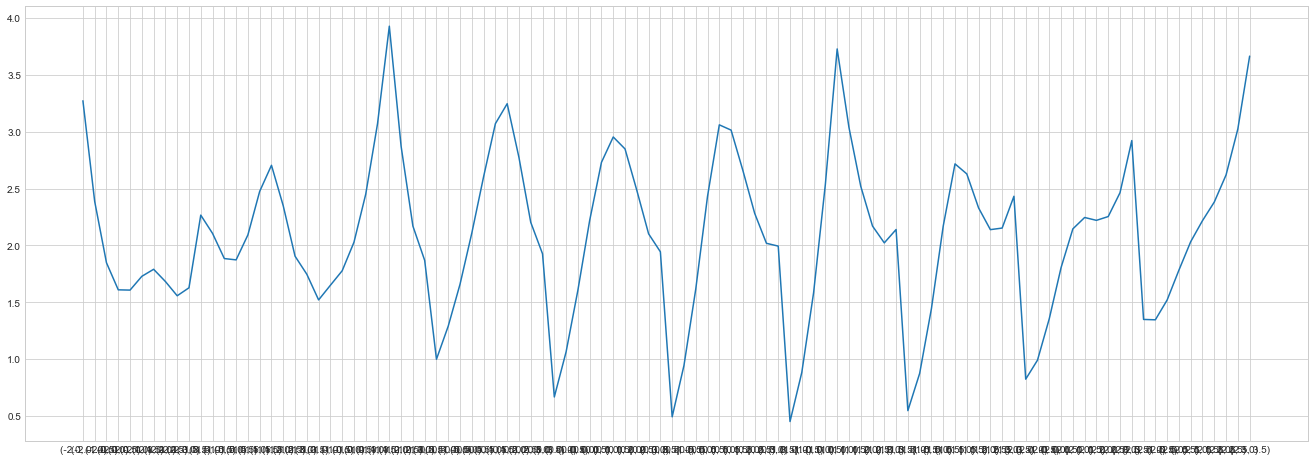

In [40]:
initial_prediction = compute_trilateration()

### Experiment - Make several runs on Trilateration
This experiment allows to check the consistency of the predictions

In [41]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max']
runs = list(range(1, 31))
predictions = list()
actual = list()
results_stats = list()
for run in runs:
    compute_distance(flag=1)
    prediction = compute_trilateration(flag=1)
    predictions.append(prediction)
    actual.append(initial_prediction)
results = list(zip(actual,predictions))
error_dataframe = pd.DataFrame(results,columns=['Actual','Prediction'])
observed_errors = list()
for index, row in error_dataframe.iterrows():
        x1 = row['Actual']
        x2 = row['Prediction']
        error = math.hypot(x2[0] - x1[0], x2[1] - x1[1])
        observed_errors.append(error)
error = pd.DataFrame(observed_errors, columns=["error"])
result = error_dataframe.join(error)
display(result)
stats = structure_data(result)
results_stats.append(stats)
statistics = pd.DataFrame(columns=statistical_cols,data=results_stats)
display(statistics)

PREDICTION is (1.0, -1.0)
PREDICTION is (1.0, -1.0)
PREDICTION is (1.0, -1.0)
PREDICTION is (1.0, -1.0)
PREDICTION is (1.0, -1.0)
PREDICTION is (1.0, -1.0)
PREDICTION is (1.0, -1.0)
PREDICTION is (1.0, -1.0)
PREDICTION is (1.0, -1.0)
PREDICTION is (1.0, -1.0)
PREDICTION is (1.0, -1.0)
PREDICTION is (1.0, -1.0)
PREDICTION is (1.0, -1.0)
PREDICTION is (1.0, -1.0)
PREDICTION is (1.0, -1.0)
PREDICTION is (1.0, -1.0)
PREDICTION is (1.0, -1.0)
PREDICTION is (1.0, -1.0)
PREDICTION is (1.0, -1.0)
PREDICTION is (1.0, -1.0)
PREDICTION is (1.0, -1.0)
PREDICTION is (1.0, -1.0)
PREDICTION is (1.0, -1.0)
PREDICTION is (1.0, -1.0)
PREDICTION is (1.0, -1.0)
PREDICTION is (1.0, -1.0)
PREDICTION is (1.0, -1.0)
PREDICTION is (1.0, -1.0)
PREDICTION is (1.0, -1.0)
PREDICTION is (1.0, -1.0)


,Actual,Prediction,error
0,"(1.0, -1.0)","(1.0, -1.0)",0.0
1,"(1.0, -1.0)","(1.0, -1.0)",0.0
2,"(1.0, -1.0)","(1.0, -1.0)",0.0
3,"(1.0, -1.0)","(1.0, -1.0)",0.0
4,"(1.0, -1.0)","(1.0, -1.0)",0.0
5,"(1.0, -1.0)","(1.0, -1.0)",0.0
6,"(1.0, -1.0)","(1.0, -1.0)",0.0
7,"(1.0, -1.0)","(1.0, -1.0)",0.0
8,"(1.0, -1.0)","(1.0, -1.0)",0.0
9,"(1.0, -1.0)","(1.0, -1.0)",0.0


,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Experiment - Having data labeled to a certain position, can the algorithm correctly figure the position